# Computes loads from flow-weighted data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook

### Universal Constants

In [193]:
start_date = "2010-1-1"
end_date = "2013-1-1"

### Flow Constants
All flow related constants go here. Look at the variable name for hints on what the file or constant may mean.
1. *lab_flow* is the raw flow file that is available. Typically 15 minutes to 1 hour flow. The file should have two columns **timestamp** and **flow_cfs**
2. *other_flow* is flow file that will be used first to fill missing flow (missing flow is defined later). For Potomac River this may be the USGS instantaneous flow file for other stations this may be computed based on relations to outer stations. The file should have two columns **timestamp** and **flow_cfs**
3. *impute_flow_if_missing_for_min* flow will be considered missing if there is no flow for this many minutes. Only if there is a gap > the impute_flow_if_missing_for_min then the other_flow file or linear interpolation (in that order) will be used. 
4. If the gap is more than *dont_impute_if_greater_for_min* and there in no other_flow file to fill form the program will quit. To remedy this make sure in the other_flow there are no missing data for more than this interval. For Potomac, USGS daily flow may be used. 

In [3]:
lab_flow = "mwcog.owml.vt.edu.flo_PR01.csv" 
other_flow = "usgs_flow.csv"
impute_flow_if_missing_for_min = 2*60
dont_interpolate_if_greater_for_min = 25*60

In [4]:
f_l = pd.read_csv(lab_flow)
f_l["timestamp"] = pd.to_datetime(f_l.timestamp) # string to timestamp datatype
f_l = f_l.sort_values("timestamp") # sorting just in case
t2 = f_l.ix[1:,"timestamp"].reset_index(drop=True) # shifting series by one
f_l["timestamp2"] =t2 # adding timestamp2

f_o = pd.read_csv(other_flow)
f_o["timestamp"] = pd.to_datetime(f_o.timestamp)
f_o = f_o.sort_values("timestamp")
t2 = f_o.ix[1:,"timestamp"].reset_index(drop=True)
f_o["timestamp2"] =t2

#### Missing flow data to be filled

In [5]:
# Computing difference indervals 
f_l['diff'] = f_l["timestamp2"]-f_l["timestamp"]
missing = f_l[f_l["diff"]>np.timedelta64(impute_flow_if_missing_for_min,"m")] # missing to be filled
print ("missing to be filled")
print(missing)
#filling missing from the other time series
for index, row in missing.iterrows():
    f_l = f_l.append(f_o.ix[(f_o["timestamp"]>row["timestamp"]) & (f_o["timestamp2"]<row["timestamp2"])])


missing to be filled
                timestamp  flow_cfs          timestamp2            diff
2730  2010-02-04 11:00:00     16772 2010-02-05 00:00:00 0 days 13:00:00
18095 2011-01-13 08:00:00      1448 2011-01-14 00:00:00 0 days 16:00:00
42766 2012-05-21 06:00:00     10011 2012-05-29 07:00:00 8 days 01:00:00
43951 2012-06-29 09:00:00      2450 2012-07-01 00:00:00 1 days 15:00:00


In [6]:
# recompute f_l to check new differences
f_l.drop(["timestamp2","diff"],axis =1 ,inplace=True)
f_l = f_l.sort_values("timestamp") # sorting to make new addition take the right spot
f_l = f_l.reset_index(drop=True) # indexes mean nothing...droping them
t2 = f_l.ix[1:,"timestamp"].reset_index(drop=True) # shifting series by one
f_l["timestamp2"] =t2 # adding timestamp2
f_l['diff'] = f_l["timestamp2"]-f_l["timestamp"] # new difference intervals
missing = f_l[f_l["diff"]>np.timedelta64(dont_interpolate_if_greater_for_min,"m")] # critical missing
if len(missing) >0:
    print (missing)
    raise ValueError("Even after filing we have large data gaps (more than {} min limit). Find the missing data!".format(dont_interpolate_if_greater_for_min))
else:
    print("Flow series ready for interpolation")
    
f_l=f_l.set_index("timestamp")

Flow series ready for interpolation


In [195]:
flow_ts=f_l["flow_cfs"]
flow_ts = flow_ts.resample("T").mean() # if there are more that 2 datapoints within 1 min, mean will be computed
flow_ts = pd.Series(flow_ts)
# flow_ts = flow_ts.interpolate(method="spline", order = 3)
flow_ts = flow_ts.interpolate(method='time')
flow_ts=flow_ts.loc[pd.to_datetime(start_date):pd.to_datetime(end_date)] # limit to start_date and end_date

<IPython.core.display.Javascript object>


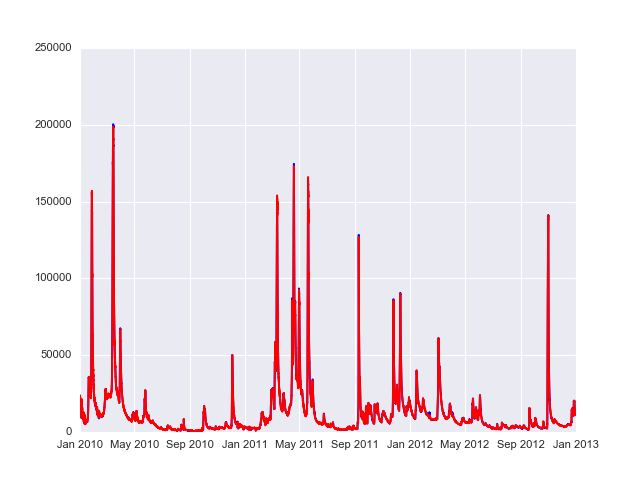

<IPython.core.display.Javascript object>


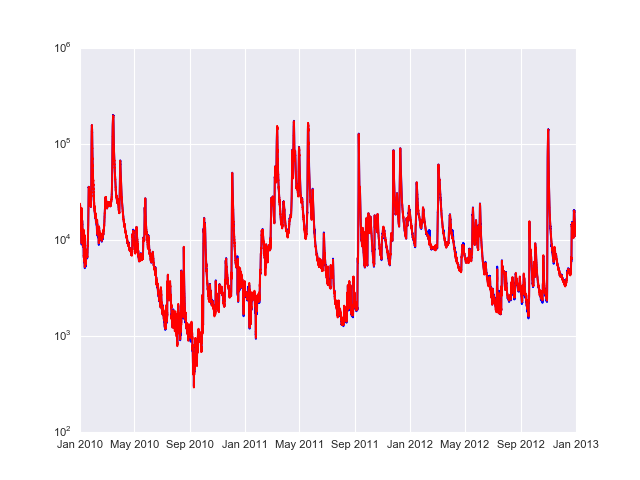

In [197]:
plt.figure()
plt.plot(flow_ts,'b')
plt.plot(f_o[["timestamp","flow_cfs"]].set_index("timestamp"),"r")
plt.figure()
plt.plot(flow_ts,'b')
a = plt.plot(f_o[["timestamp","flow_cfs"]].set_index("timestamp"),"r")
plt.yscale('log')

In [196]:
flow_ts

timestamp
2010-01-01 00:00:00    23500.000000
2010-01-01 00:01:00    23500.000000
2010-01-01 00:02:00    23500.000000
2010-01-01 00:03:00    23500.000000
2010-01-01 00:04:00    23500.000000
2010-01-01 00:05:00    23500.000000
2010-01-01 00:06:00    23500.000000
2010-01-01 00:07:00    23500.000000
2010-01-01 00:08:00    23500.000000
2010-01-01 00:09:00    23500.000000
2010-01-01 00:10:00    23500.000000
2010-01-01 00:11:00    23500.000000
2010-01-01 00:12:00    23500.000000
2010-01-01 00:13:00    23500.000000
2010-01-01 00:14:00    23500.000000
2010-01-01 00:15:00    23500.000000
2010-01-01 00:16:00    23490.666667
2010-01-01 00:17:00    23481.333333
2010-01-01 00:18:00    23472.000000
2010-01-01 00:19:00    23462.666667
2010-01-01 00:20:00    23453.333333
2010-01-01 00:21:00    23444.000000
2010-01-01 00:22:00    23434.666667
2010-01-01 00:23:00    23425.333333
2010-01-01 00:24:00    23416.000000
2010-01-01 00:25:00    23406.666667
2010-01-01 00:26:00    23397.333333
2010-01-01 00:27:0

### Concentration constants
1. *conc_file* is the non-storm concentration file. Note that it does not do anything to the below detect. If you want censored data handling do it manually in the input file. Way it is configured this will generate highest load. Typically load will be < what is computed. Expects columns **timestamp** and **conc_mg_l**
2. *storms_file* is the file with storms. Expects columns **start**, **end**, and **conc_mg_l**.

In [199]:
conc_file = "mwcog.owml.vt.edu.TN_PR01_part.csv"
storm_file = "mwcog.owml.vt.edu.TN_PR01_storms_part.csv" 

In [200]:
storms = pd.read_csv(storm_file).sort_values("start")
storms["start"] = pd.to_datetime(storms.start) 
storms["end"] = pd.to_datetime(storms.end) 
bf_conc = pd.read_csv(conc_file).sort_values("timestamp")
bf_conc["timestamp"] = pd.to_datetime(bf_conc["timestamp"]) 

#### Use the graph below to identify missing storms. If there are missing storms edit the *storm_file* to add missing storms.
Add start and end times and leave concentration blank (_**NO SPACE**_) to auto compute. Concentration is based on a linear model developed for concentration (with all data in storms file) using duration, and peak flow as predictors. 

<IPython.core.display.Javascript object>


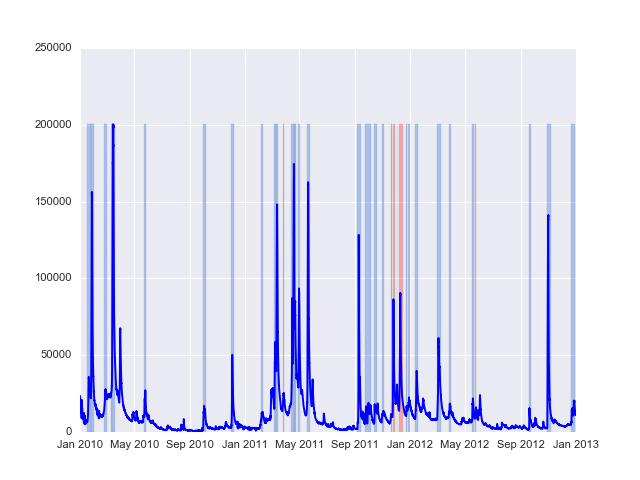

<IPython.core.display.Javascript object>


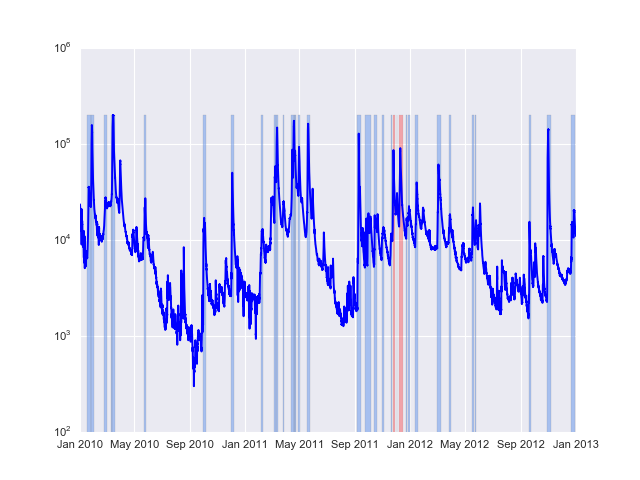

In [201]:
# visualizing storms
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates
max_flow= max(flow_ts)
plt.figure()
plt.plot(flow_ts,'b')
ax = plt.gca()
for index, row in storms.iterrows():
    if pd.notnull(row["conc_mg_l"]):
        ax.add_patch(Rectangle((mdates.date2num(row["start"]),0),mdates.date2num(row["end"])-mdates.date2num(row["start"]),max_flow,ec="gray",
                           fc="CornflowerBlue",alpha=0.5))
    else:
        ax.add_patch(Rectangle((mdates.date2num(row["start"]),0),mdates.date2num(row["end"])-mdates.date2num(row["start"]),max_flow,ec="gray",
                           fc="Red", alpha = 0.3))
        
plt.figure()
plt.plot(flow_ts,'b')
ax = plt.gca()
for index, row in storms.iterrows():
    if pd.notnull(row["conc_mg_l"]):
        ax.add_patch(Rectangle((mdates.date2num(row["start"]),0),mdates.date2num(row["end"])-mdates.date2num(row["start"]),max_flow,ec="gray",
                           fc="CornflowerBlue",alpha=0.5))
    else:
        ax.add_patch(Rectangle((mdates.date2num(row["start"]),0),mdates.date2num(row["end"])-mdates.date2num(row["start"]),max_flow,ec="gray",
                           fc="Red", alpha = 0.3))
plt.yscale('log')

In [202]:

storms["duration"] = (storms["end"]-storms["start"])/np.timedelta64(1, 'm')
storms["peak"] = storms.apply(lambda x: np.max(flow_ts.ix[x['start']:x['end']]) ,axis=1)
storms["flow"] = storms.apply(lambda x: np.sum(flow_ts.ix[x['start']:x['end']]) ,axis=1) # these are in some wacky units
storms["avg_flow"] = storms["flow"]/storms["duration"]
storms["log_peak"] = np.log10(storms["peak"])
storms["log_flow"] = np.log10(storms["flow"])
storms["constant"] = 1

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: RuntimeWarning: divide by zero encountered in log10


In [203]:
# developing OLS model.. . models are terrible 
import statsmodels.api as sm
predictors = ["peak", "duration","flow","constant"]
modelvar = storms.dropna()
X = modelvar [predictors]
y = modelvar ["conc_mg_l"]
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              conc_mg_l   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.100
Method:                 Least Squares   F-statistic:                   0.02892
Date:                Wed, 21 Dec 2016   Prob (F-statistic):              0.993
Time:                        22:53:35   Log-Likelihood:                -54.820
No. Observations:                  33   AIC:                             117.6
Df Residuals:                      29   BIC:                             123.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
peak       -2.002e-06   1.09e-05     -0.183      0.8

In [204]:
estimate = storms.ix[pd.isnull(storms.conc_mg_l)]
storms.loc[pd.isnull(storms.conc_mg_l),"conc_mg_l"] = estimate.apply(lambda x:results.predict(x[predictors]) ,axis = 1)
storms

,start,end,conc_mg_l,duration,peak,flow,avg_flow,log_peak,log_flow,constant
27,2012-01-12 01:00:00,2012-01-18 07:30:00,1.930000,9030.0,39830.0,2.303837e+08,25513.140642,4.600210,8.362452,1
35,2013-01-13 04:15:00,2013-01-22 01:39:00,1.970000,12804.0,NaN,0.000000e+00,0.000000,NaN,-inf,1
2,2010-01-17 13:00:00,2010-01-25 03:30:00,2.200000,10950.0,35886.0,2.542362e+08,23217.919315,4.554925,8.405237,1
3,2010-01-25 03:30:00,2010-01-31 15:01:00,2.410000,9331.0,156310.0,6.575586e+08,70470.328046,5.193987,8.817934,1
21,2011-10-13 06:00:00,2011-10-18 15:29:00,1.950000,7769.0,18110.0,1.092489e+08,14062.162119,4.257918,8.038417,1
22,2011-10-29 08:15:00,2011-11-03 00:16:00,1.730000,6721.0,13571.0,7.590362e+07,11293.500967,4.132612,7.880262,1
33,2012-10-29 04:45:00,2012-11-05 16:35:00,2.740000,10790.0,141030.0,5.428231e+08,50307.978730,5.149312,8.734658,1
23,2011-11-18 11:30:00,2011-11-20 16:09:00,1.540000,3159.0,11686.0,3.420735e+07,10828.538145,4.067666,7.534119,1
36,2011-11-23 08:00:00,2011-11-28 03:00:00,2.249996,6900.0,86456.0,3.092217e+08,44814.735797,4.936795,8.490270,1
9,2010-12-01 09:15:00,2010-12-07 06:43:00,2.620000,8488.0,50206.0,1.988887e+08,23431.748056,4.700756,8.298610,1


In [205]:
#create per min baseflow concentration
bf_conc=bf_conc.set_index("timestamp")
conc_ts=bf_conc["conc_mg_l"]
conc_ts = conc_ts.resample("T").mean() # if there are more that 2 data points within 1 min, mean will be computed
conc_ts = pd.Series(conc_ts)
conc_ts = conc_ts.interpolate(method='time')
conc_ts = conc_ts[pd.to_datetime(start_date):pd.to_datetime(end_date)]

In [206]:
conc_ts

timestamp
2010-01-01 00:00:00    2.418759
2010-01-01 00:01:00    2.418778
2010-01-01 00:02:00    2.418797
2010-01-01 00:03:00    2.418816
2010-01-01 00:04:00    2.418836
2010-01-01 00:05:00    2.418855
2010-01-01 00:06:00    2.418874
2010-01-01 00:07:00    2.418894
2010-01-01 00:08:00    2.418913
2010-01-01 00:09:00    2.418932
2010-01-01 00:10:00    2.418951
2010-01-01 00:11:00    2.418971
2010-01-01 00:12:00    2.418990
2010-01-01 00:13:00    2.419009
2010-01-01 00:14:00    2.419028
2010-01-01 00:15:00    2.419048
2010-01-01 00:16:00    2.419067
2010-01-01 00:17:00    2.419086
2010-01-01 00:18:00    2.419106
2010-01-01 00:19:00    2.419125
2010-01-01 00:20:00    2.419144
2010-01-01 00:21:00    2.419163
2010-01-01 00:22:00    2.419183
2010-01-01 00:23:00    2.419202
2010-01-01 00:24:00    2.419221
2010-01-01 00:25:00    2.419240
2010-01-01 00:26:00    2.419260
2010-01-01 00:27:00    2.419279
2010-01-01 00:28:00    2.419298
2010-01-01 00:29:00    2.419318
                         ...  

In [212]:
# generating storm time concentartions timeseries
storm_ts = pd.Series()
for index,row in storms.iterrows():
    i = pd.date_range(start= row["start"], end=row["end"], freq="T")
    s = pd.Series(row["conc_mg_l"], index=i)
    storm_ts= storm_ts.append(s)
    
storm_ts=storm_ts[[x for x in storm_ts.index if x >=pd.to_datetime(start_date) and x <=pd.to_datetime(end_date)]]

In [213]:
storm_ts

2012-01-12 01:00:00    1.93
2012-01-12 01:01:00    1.93
2012-01-12 01:02:00    1.93
2012-01-12 01:03:00    1.93
2012-01-12 01:04:00    1.93
2012-01-12 01:05:00    1.93
2012-01-12 01:06:00    1.93
2012-01-12 01:07:00    1.93
2012-01-12 01:08:00    1.93
2012-01-12 01:09:00    1.93
2012-01-12 01:10:00    1.93
2012-01-12 01:11:00    1.93
2012-01-12 01:12:00    1.93
2012-01-12 01:13:00    1.93
2012-01-12 01:14:00    1.93
2012-01-12 01:15:00    1.93
2012-01-12 01:16:00    1.93
2012-01-12 01:17:00    1.93
2012-01-12 01:18:00    1.93
2012-01-12 01:19:00    1.93
2012-01-12 01:20:00    1.93
2012-01-12 01:21:00    1.93
2012-01-12 01:22:00    1.93
2012-01-12 01:23:00    1.93
2012-01-12 01:24:00    1.93
2012-01-12 01:25:00    1.93
2012-01-12 01:26:00    1.93
2012-01-12 01:27:00    1.93
2012-01-12 01:28:00    1.93
2012-01-12 01:29:00    1.93
                       ... 
2011-09-13 19:04:00    2.40
2011-09-13 19:05:00    2.40
2011-09-13 19:06:00    2.40
2011-09-13 19:07:00    2.40
2011-09-13 19:08:00 

In [214]:
# replace conc_ts values with storm_ts
conc_ts[storm_ts.index]=storm_ts.values

In [218]:
ts_min = pd.concat([flow_ts,conc_ts],axis=1)


In [223]:
cubicft_to_l = 28.3168
mg_to_lbs = 2.20462e-6
conversion = 60*cubicft_to_l*mg_to_lbs
ts_min ["load_lbs"] = ts_min["flow_cfs"]*ts_min["conc_mg_l"]*conversion

In [224]:
ts_min

,flow_cfs,conc_mg_l,load_lbs
timestamp,,,
2010-01-01 00:00:00,23500.000000,2.418759,212.906809
2010-01-01 00:01:00,23500.000000,2.418778,212.908505
2010-01-01 00:02:00,23500.000000,2.418797,212.910202
2010-01-01 00:03:00,23500.000000,2.418816,212.911899
2010-01-01 00:04:00,23500.000000,2.418836,212.913596
2010-01-01 00:05:00,23500.000000,2.418855,212.915292
2010-01-01 00:06:00,23500.000000,2.418874,212.916989
2010-01-01 00:07:00,23500.000000,2.418894,212.918686
2010-01-01 00:08:00,23500.000000,2.418913,212.920383


<IPython.core.display.Javascript object>


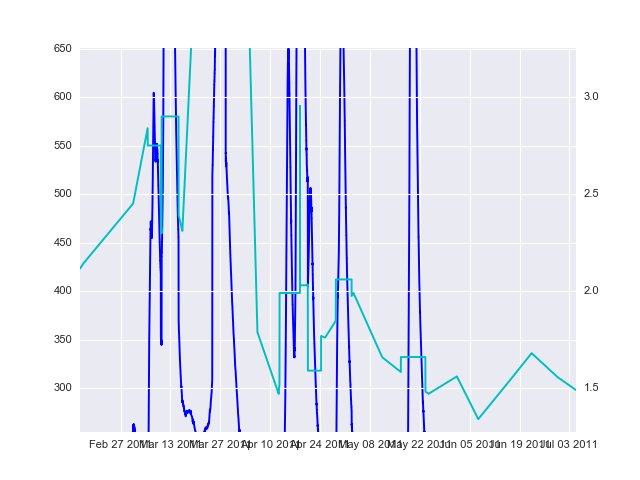

In [228]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(ts_min["load_lbs"],'b')
ax2.plot(ts_min["conc_mg_l"],'c')

In [237]:
daily_flow = ts_min["flow_cfs"].resample("D").mean()
daily_conc = ts_min["conc_mg_l"].resample("D").mean()
daily_load = ts_min["load_lbs"].resample("D").sum() # using load per minute to get daily load not daily average
daily_flow.to_csv("daily_flow_cfs.csv")
daily_conc.to_csv("daily_conc_mg_l_{}.csv".format(conc_file))
daily_load.to_csv("daily_load_lbs_{}.csv".format(conc_file))

In [238]:
annual_flow = ts_min["flow_cfs"].resample("A").mean()
annual_conc = ts_min["conc_mg_l"].resample("A").mean()
annual_load = ts_min["load_lbs"].resample("A").sum() # using load per minute to get annual load not annual average
annual_flow.to_csv("annual_flow_cfs.csv")
annual_conc.to_csv("annual_conc_mg_l_{}.csv".format(conc_file))
annual_load.to_csv("annual_load_lbs_{}.csv".format(conc_file))